In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tf
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

/Users/aj/Desktop/work/virtualenvs/edx/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


PyTorch version: 2.0.1
Torchvision version: 0.15.2
CUDA is available: False


In [21]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Load the stack of HAADF images

In [15]:
haadf_stack = tf.imread("../primary_data/main_mosaic_5by6_haadf.tiff")   

### Get and inspect a single tile

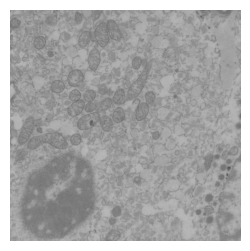

In [16]:
tile_idx = 0
image = haadf_stack[tile_idx,:,:]
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis('off')
plt.show()

### Automatic mask generator

In [18]:
sam_checkpoint = "../primary_data/sam_vit_h_4b8939.pth"
model_type = "vit_h"
#device = "cuda"
#device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

### Mask generator for the tile

In [19]:
masks = mask_generator.generate(image)
print('The number of detected objects', len(masks))
print(masks[0].keys())

The number of detected objects 390
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Display the segmentation

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Mask generator options 

In [27]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

### New mask

In [28]:
masks2 = mask_generator_2.generate(image)
len(masks2)

458

### Display the new segmentation

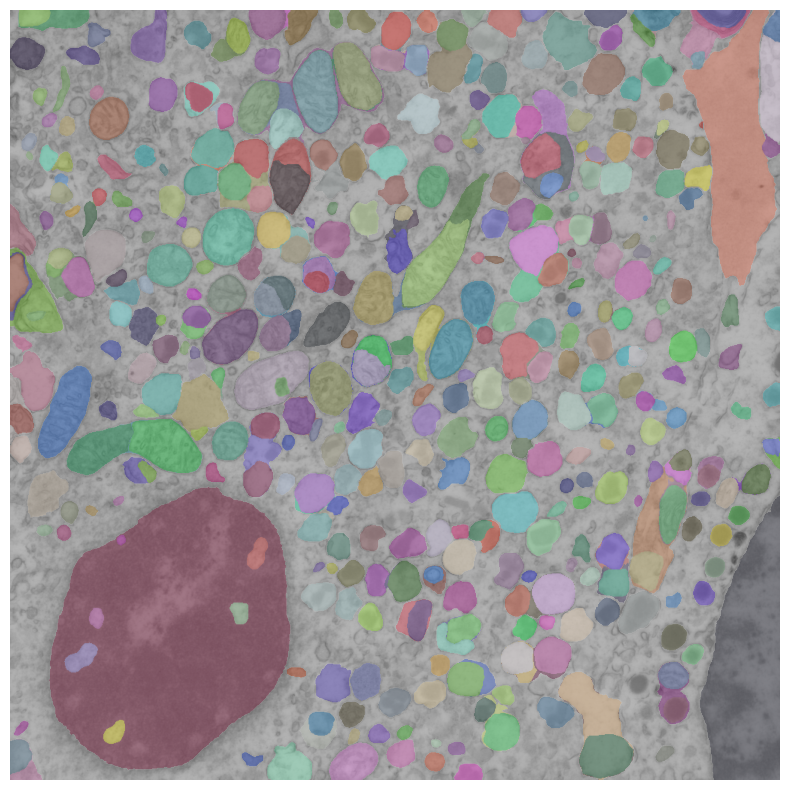

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 